# 28th April 2024 - Devon Networks

Can we make a Devon style task modularise?

In [1]:
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt
from jax import vmap, value_and_grad, grad, jit, random
import jax.nn as jnn
import math
import optax
import scipy

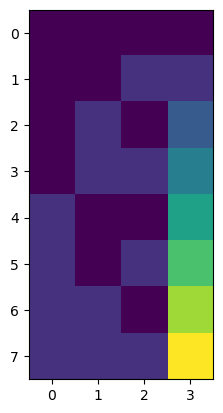

In [122]:
# Let's create the data
data_option = 1

if data_option == 0:
    data = np.zeros([8, 8+3])
    data[:,3:] = np.eye(8)
    input_plus_bias_size = 12
elif data_option == 1:
    data = np.zeros([8, 4])
    data[:,3] = np.arange(8)
    input_plus_bias_size = 5

counter = 0
for n in range(2):
    for m in range(2):
        for l in range(2):
            data[counter,0] = n
            data[counter,1] = m
            data[counter,2] = l
            counter += 1

plt.imshow(data)
data = data.T



In [123]:
# Let's try optimisation with implicit R for now
H = 20
I = np.random.normal(0,1, [H,input_plus_bias_size])
data_with_bias = np.vstack([data, np.ones([1,data.shape[1]])])
act_reg = 2
weight_reg = 2

@jit
def generate_rep(I, inputs):
    g = jnn.relu(I@inputs)
    g_bias = jnp.vstack([g, jnp.ones(g.shape[1])[None,:]])
    return g_bias

if weight_reg == 1:
    @jit
    def loss_weight_I(I):
        return jnp.sum(jnp.abs(I[:,:-1]))
        
    @jit
    def loss_R(R):
        R_sub = R[:-1,:]
        return jnp.sum(jnp.abs(R_sub))
        
elif weight_reg == 2:
    @jit
    def loss_weight_I(I):
        return jnp.sum(jnp.power(I[:,:-1],2))
        
    @jit
    def loss_R(R):
        R_sub = R[:-1,:]
        return jnp.sum(jnp.power(R_sub, 2))

@jit
def generate_R(g, outputs):
    mat0 = jnp.matmul(g, g.T)
    mat1 = jnp.matmul(g, outputs.T)
    mat2 = jnp.matmul(jnp.linalg.inv(mat0 + 0.01*jnp.eye(H+1)), mat1)
    return mat2

@jit
def loss_fit(g, R, outputs):
    preds = R.T@g
    return jnp.linalg.norm(outputs - preds) 


if act_reg == 2:
    @jit
    def loss_act(g):
        return jnp.sum(jnp.power(g[:-1,:], 2))
elif act_reg == 1:
    @jit
    def loss_act(g):
        return jnp.sum(jnp.abs(g[:-1,:]))
elif act_reg == 0:
    @jit
    def loss_act(g):
        return 0
        
mu_fit = 100000
mu_G = 5
mu_R = 1
mu_I = 1
fit_thresh = 0.01

@jit
def loss(params, inputs, outputs):
    g = generate_rep(params["I"], inputs)
    R = generate_R(g, outputs)

    return mu_fit*jnn.relu(loss_fit(g, R, outputs)-fit_thresh) + mu_G*loss_act(g) + mu_I*loss_weight_I(params["I"]) + mu_R*loss_weight_I(R)
    
@jit
def update(params, inputs, outputs, opt_state):
    """ Compute the gradient for a batch and update the parameters """
    value, grads = value_and_grad(loss)(params, inputs, outputs)
    updates, opt_state = optimizer.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    return params, opt_state, value

random_seed = 4341321432
learning_rate = 1e-4

re_init = 1
if re_init:
    key = random.PRNGKey(random_seed)
    I = random.normal(key, (H, input_plus_bias_size))*0.001
    I = I.at[:,-1].set(2)
    optimizer = optax.adam(learning_rate)
    # Obtain the `opt_state` that contains statistics for the optimizer.
    params = {'I': I}
    opt_state = optimizer.init(params)
print(loss(params, data_with_bias, data))
min_loss = np.infty

605423.75


In [124]:
# Optimisation, run and re-run until it stops hitting new records
T = 10000000
print_iter = 10000

for t in range(T):
    params, opt_state, loss = update(params, data_with_bias, data, opt_state)

    if t % print_iter == 0:
        g = generate_rep(params["I"], data_with_bias)
        R = generate_R(g, data)

        L_f = loss_fit(g, R, data)
        L_a = loss_act(g)
        L_R = loss_weight_I(R)
        L_I = loss_weight_I(params["I"])    
        print(f"Step {t}, Loss: {loss:.5f}, Fit: {L_f:.5f}, Act: {L_a:.5f}, R: {L_R:.5f}, I: {L_I:.5f}")
        #print(f"Step {t}, Loss: {loss:.5f}")#, Fit: {L_f:.5f}, Act: {L_a:.5f}, Wei: {L_w:.5f}, R: {L_R:.5f}, Pos: {L_p:.5f}, PI: {L_PI:.5f}")

        min_this_step = 0

    if loss < min_loss:
        params_best = params
        min_loss = loss
        if min_this_step == 0:
            print(f'New min! {loss}')
            min_this_step = 1

Step 0, Loss: 605423.75000, Fit: 5.90994, Act: 639.97845, R: 28.40848, I: 0.00010
New min! 605423.75
Step 10000, Loss: 2099.67871, Fit: 0.01306, Act: 366.18161, R: 2.40731, I: 2.20290
New min! 1997.0731201171875
Step 20000, Loss: 623.20801, Fit: 0.01127, Act: 120.38751, R: 1.41638, I: 5.02388
New min! 608.3815307617188
Step 30000, Loss: 446.62769, Fit: 0.01005, Act: 88.04756, R: 1.46594, I: 4.88084
New min! 446.16998291015625
Step 40000, Loss: 340.02991, Fit: 0.00952, Act: 66.76359, R: 1.55699, I: 4.63275
New min! 340.0299072265625
Step 50000, Loss: 290.88324, Fit: 0.00985, Act: 56.93853, R: 1.63279, I: 4.56345
New min! 290.44696044921875
Step 60000, Loss: 317.63376, Fit: 0.01031, Act: 49.74508, R: 1.63089, I: 4.67130
New min! 254.8871612548828
Step 70000, Loss: 213.55914, Fit: 0.00976, Act: 41.40572, R: 1.63945, I: 4.89095
New min! 212.92030334472656
Step 80000, Loss: 235.52324, Fit: 0.00925, Act: 38.00290, R: 1.65101, I: 5.06804
New min! 196.1227264404297
Step 90000, Loss: 193.24194,

KeyboardInterrupt: 

In [125]:
print(min_loss)

135.87476


In [126]:
g = generate_rep(params_best["I"], data_with_bias)
g.shape

(21, 8)

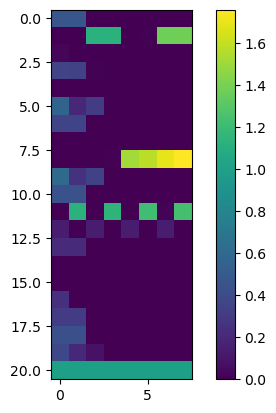

In [127]:
plt.imshow(g)
plt.colorbar()

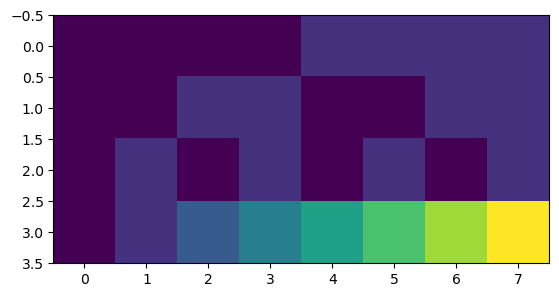

In [128]:
plt.imshow(data)

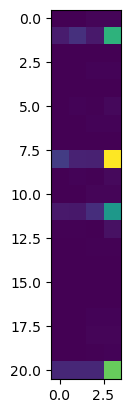

In [129]:
plt.imshow(g@data.T)

In [102]:
np.power(-2, 1)

-2

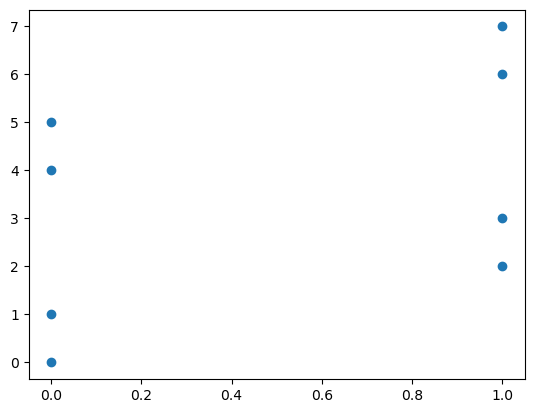

In [134]:
plt.scatter(data[1,:], data[3,:])